In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, precision_recall_fscore_support

tokenizer1 = AutoTokenizer.from_pretrained("monsoon-nlp/hindi-tpu-electra")
tokenizer2 = AutoTokenizer.from_pretrained("monsoon-nlp/hindi-bert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("../data/constraint_hindi_train.csv")
taglist = list()
for i in range(len(df)):
    tags = df.iloc[i]["Labels Set"].split(",")
    for tag in tags:
        if(tag not in taglist):
            taglist.append(tag)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, datapath):
        
        self.df = pd.read_csv(datapath)
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer1.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        electra_input_ids = encoding['input_ids']
        electra_attention_mask = encoding['attention_mask']
        labels = np.zeros(5)
        tags = self.df.iloc[idx]["Labels Set"].split(",")
        for tag in tags:
            labels[taglist.index(tag)] = 1
        
        sentence = self.df.iloc[idx]["Post"]
        encoding = tokenizer2.encode_plus(sentence,add_special_tokens=True,max_length=64,truncation=True,pad_to_max_length=True,return_attention_mask=True)
        bert_input_ids = encoding['input_ids']
        bert_attention_mask = encoding['attention_mask']
        
        return np.array(electra_input_ids), np.array(electra_attention_mask),np.array(bert_input_ids), np.array(bert_attention_mask), labels
trainset = Dataset("../data/constraint_hindi_train.csv")
valset = Dataset("../data/constraint_hindi_valid.csv")

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle=False)

In [4]:
class electra_model(nn.Module): ## CNN + Linear (single linear)
    def __init__(self):
        super(electra_model, self).__init__()
        # self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-bert", output_hidden_states=True)
        self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-tpu-electra", output_hidden_states=True)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 768), padding=(1,0)) for i in range(12)])
        self.pools = nn.ModuleList([nn.MaxPool1d(kernel_size=64) for i in range(12)])
        self.linear = nn.Linear(in_features=12, out_features=5)
    def forward(self,sent,mask):
        seq = self.bert(sent,mask)[1] # len 13
        hidden_states = seq[1:] # len 12, each (64, 64, bert_hidden_size)
        cnn_out = torch.empty(0).to("cuda:1")
        for i, state in enumerate(hidden_states):
            state = torch.unsqueeze(state, dim=1) # (64, 1, 64, bert_hidden_size)
            out = self.convs[i](state) # (64, 1, 64, 1)
            out = out.squeeze(dim=3)
            out = self.pools[i](out) # (64, 1, 1)
            out = out.squeeze(dim=2) # (64, 1)
            cnn_out = torch.cat([cnn_out, out], dim=1)

        seq = self.linear(cnn_out)
        return seq
class bert_model(nn.Module): ## Linear on bert (single linear) only CLS token
    def __init__(self):
        super(bert_model, self).__init__()
        self.bert = AutoModel.from_pretrained("monsoon-nlp/hindi-bert")
        self.linear = nn.Linear(in_features=256, out_features=5)
    def forward(self,sent,mask):
        seq = self.bert(sent,mask)[0]
#         seq = torch.mean(seq, dim = 1).squeeze()
        seq = torch.transpose(seq,0,1)[0]
        seq = self.linear(seq)
        return seq
    
class ensemble(nn.Module): ## Linear on bert (single linear) only CLS token
    def __init__(self):
        super(ensemble, self).__init__()
        self.bert = bert_model()
        self.electra = electra_model()
        self.linear = nn.Linear(in_features=10,out_features=5,bias=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self,electra_sent,electra_mask,bert_sent,bert_mask):
        bert_op = self.bert(bert_sent.to("cuda:0"),bert_mask.to("cuda:0"))
        electra_op = self.electra(electra_sent.to("cuda:1"),electra_mask.to("cuda:1"))
        op = 0.5*bert_op.to("cuda:1") + 0.5*electra_op
        op = self.sigmoid(op)
        return op

In [5]:
# for batch in trainloader:
#     break
# model = ensemble()
# model.to(device)
# batch[0],batch[1],batch[2],batch[3],batch[4]=batch[0].to(device),batch[1].to(device),batch[2].to(device),batch[3].to(device),batch[4].to(device)

In [6]:
model = ensemble()
model.bert = model.bert.to("cuda:0")
model.electra = model.electra.to("cuda:1")

In [7]:
train_losses = list()
val_losses=list()
val_accuracy=list()
loss = nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
for epoch in tqdm(range(25)):
    model.train()
    total_loss=0
    num_batches = 0
    ## main model training loop
    for batch in (trainloader):
        optimizer.zero_grad()
        logits = model(batch[0],batch[1],batch[2],batch[3])
        labels = batch[4].to("cuda:1")
        loss_value = loss(logits.float(),labels.float())
        loss_value.backward()
        optimizer.step()
        total_loss+=loss_value.item()
        num_batches +=1
    train_losses.append(total_loss/num_batches)
#     if(epoch%1==0):
#         print("train loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))

    model.eval()
    total_loss=0
    num_batches = 0
    ## validation loss and accuracy calculation
    for batch in (valloader):
        logits = model(batch[0],batch[1],batch[2],batch[3])
        labels = batch[4].to("cuda:1")

        loss_value = loss(logits.float(),labels.float())
        total_loss+=loss_value.item()
        num_batches +=1
    val_losses.append(total_loss/num_batches)
    if(epoch%1==0):
        print("val loss at epoch " + str(epoch) + ":" + str(total_loss/num_batches))
        
    logits_list = np.zeros((1,5))
    labels_list = np.zeros((1,5))
    for batch in (valloader):
        logits = model(batch[0],batch[1],batch[2],batch[3]).to("cpu").detach().numpy() > 0.5
        labels = batch[4].to("cpu")
    
        logits_list = np.concatenate((logits_list,logits),0)
        labels_list = np.concatenate((labels_list,labels),0)
    val_accuracy.append(f1_score(labels_list[1:], logits_list[1:], average='weighted'))
#     if(epoch%10==0):
#         print("val accuracy after epoch "+str(epoch)+ " : " + str(f1_score(labels_list[1:], logits_list[1:], average='weighted')))    

/data/sagnik/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


val loss at epoch 0:0.4295816467810794


/data/sagnik/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val loss at epoch 1:0.375504814244522
val loss at epoch 2:0.3356429696744526
val loss at epoch 3:0.30946765169409435
val loss at epoch 4:0.29446831965214965
val loss at epoch 5:0.28390639987756966
val loss at epoch 6:0.27358798375847015
val loss at epoch 7:0.26562477448213334
val loss at epoch 8:0.26218325118781166
val loss at epoch 9:0.2574071741459659
val loss at epoch 10:0.25106937630370757
val loss at epoch 11:0.2484915204421972
val loss at epoch 12:0.24276532160644174
val loss at epoch 13:0.23934591753217685
val loss at epoch 14:0.233703313525146
val loss at epoch 15:0.2307493599446355
val loss at epoch 16:0.23143283969351766
val loss at epoch 17:0.22738309913175928
val loss at epoch 18:0.22675428951375012
val loss at epoch 19:0.22827028890763915
val loss at epoch 20:0.2227656919372517
val loss at epoch 21:0.22354802346826244
val loss at epoch 22:0.22320261383406204
val loss at epoch 23:0.2220269656733239
val loss at epoch 24:0.2220402074255435



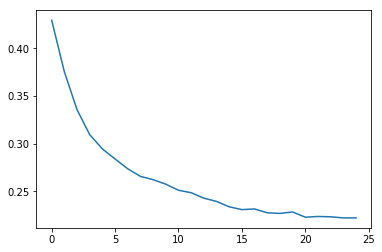

In [9]:
import matplotlib.pyplot as plt

plt.plot(val_losses)

In [10]:
from sklearn.metrics import f1_score,precision_score,recall_score

logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in (trainloader):
    logits = model(batch[0],batch[1],batch[2],batch[3]).to("cpu").detach().numpy() > 0.5
    labels = batch[4].numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
for i in range(logits_list.shape[0]):
    for j in range(logits_list.shape[1]):
        if(logits_list[i][2]==1 and j!=2):
            logits_list[i][j]=0
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))


logits_list = np.zeros((1,5))
labels_list = np.zeros((1,5))
model.eval()
for batch in (valloader):
    logits = model(batch[0],batch[1],batch[2],batch[3]).to("cpu").detach().numpy() > 0.5
    labels = batch[4].numpy()
    
    logits_list = np.concatenate((logits_list,logits),0)
    labels_list = np.concatenate((labels_list,labels),0)
    
    torch.cuda.empty_cache()
for i in range(logits_list.shape[0]):
    for j in range(logits_list.shape[1]):
        if(logits_list[i][2]==1 and j!=2):
            logits_list[i][j]=0
print(precision_score(labels_list[1:], logits_list[1:], average='weighted'))
print(recall_score(labels_list[1:], logits_list[1:], average='weighted'))
print(f1_score(labels_list[1:], logits_list[1:], average='weighted'))

/data/sagnik/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.86483720167801
0.744596312778131
0.7835380390803829
0.7718007980719844
0.6711864406779661
0.705388619241328


In [11]:
def print_conf(y_true,y_pred,i):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    matrix_hate = np.zeros((2,2))
    for i in range(len(y_true)):
        true = int(y_true[i])
        pred = int(y_pred[i])
        matrix_hate[true][pred]+=1
    print(matrix_hate)
##coordinate 0 hate
for i in range(5):
    y_true = labels_list[:,i]
    y_pred = logits_list[:,i]
    print_conf(y_true,y_pred,i)

[[675.  27.]
 [ 81.  29.]]
[[677.  32.]
 [ 58.  45.]]
[[369.   8.]
 [ 27. 408.]]
[[732.   3.]
 [ 76.   1.]]
[[615.  37.]
 [ 49. 111.]]


In [1]:
!nvidia-smi

Fri Dec  4 19:45:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 31%   52C    P0    79W / 250W |     18MiB / 11177MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 27%   

In [ ]:
!kill -9 947